In [1]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF # kernel for GPs
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


# Cross-Validation and Hyperparameters tuning
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reading the data

In [2]:
df=pd.read_csv('MNDO_full_set_logS.csv')

**We drop G_sol, volume and SASA variables**

In [10]:
df.drop(['G_sol','volume','SASA'],axis=1,inplace=True)

### Getting data ready for ML model 

In [13]:
# Features and Targets
ftrs_cols = list(df.columns)
[ftrs_cols.remove(x) for x in ['Compound','LogS']]
ftrs = df[ftrs_cols]

trgt = df['LogS']

ftrs = pd.DataFrame(ftrs, columns=ftrs_cols)

In [14]:
# Train and test split (80 - 20)
xtrn, xtst, ytrn, ytst = train_test_split(ftrs, trgt, test_size=0.20, random_state=10)

In [15]:
# Scaling data to same scales.. Helpful in some of the models such as PCR etc.
scaler = StandardScaler()
xtrn = scaler.fit_transform(xtrn)
xtst = scaler.transform(xtst)

ytrn.reset_index(drop=True,inplace=True)
ytst.reset_index(drop=True,inplace=True)

print('X-train: ', xtrn.shape)
print('Y-train: ', ytrn.shape)
print('--')
print('X-test: ', xtst.shape)
print('Y-test: ', ytst.shape)

X-train:  (720, 10)
Y-train:  (720,)
--
X-test:  (180, 10)
Y-test:  (180,)


# ML - Models

**Defining the %P±0.7 and %P±1.0 score metrics, for model evaluation.**

In [16]:
def within_range(list1, list2, range2): 
    x=0
    for i in range(len(list2)):
        if (list1[i]-range2)<= list2[i] <= (list1[i]+range2):
            x+=1 
    return((float(x)/(len(list2)))*100)

**Defining the get_scores function to evaluate the model performed**

In [17]:
# RMSE, r2_score, Pearsonr-squared (Correlation coefficient squared) ,%LogS±0.7 and %LogS±1.0 scores.

def get_scores(ytrn, ypred, test=False):
    rmse_l = []
    pearson_r2_l = []
    pct_logS_7_l = []
    pct_logS_10_l = []
    
    if test:
        # RMSE
        rmse = mean_squared_error(ytrn.values, ypred, squared=False) # 'square=False' will make it return RMSE
        
        # Pearsonr2
        pearson_r,_ = pearsonr(ytrn.values, ypred)
        pearson_r2 = pearson_r**2
        
        # %LogS±0.7 
        pct_logS_7 = within_range(ytrn.values, ypred, 0.7)
        
        # %LogS±0.7 
        pct_logS_10 = within_range(ytrn.values, ypred, 1.0)
        
        return {'RMSE':rmse, 'Pearson-rsquare':pearson_r2, '%P±0.7':pct_logS_7, '%P±1.0':pct_logS_10}
    
    for i in range(len(ytrn)):
        # RMSE
        rmse = mean_squared_error(ytrn[i].values, ypred[i], squared=False) # 'square=False' will make it return RMSE
        rmse_l.append(rmse)
        
        # Pearsonr2
        pearson_r,_ = pearsonr(ytrn[i].values, ypred[i])
        pearson_r2 = pearson_r**2
        pearson_r2_l.append(pearson_r2)
        
        # %LogS±0.7 
        pct_logS_7 = within_range(ytrn[i].values, ypred[i], 0.7)
        pct_logS_7_l.append(pct_logS_7)
        
        # %LogS±0.7 
        pct_logS_10 = within_range(ytrn[i].values, ypred[i], 1.0)
        pct_logS_10_l.append(pct_logS_10)
    return {'RMSE':np.mean(rmse_l), 'Pearson-rsquare':np.mean(pearson_r2_l), '%P±0.7':np.mean(pct_logS_7_l), '%P±1.0':np.mean(pct_logS_10_l)}

# Linear Regression (MLR) 

In [18]:
lin_reg=LinearRegression()

## CV

In [19]:
cv = KFold(10)
ypred = cross_val_predict(lin_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)

cv_perf = pd.DataFrame([scores], index=['OLS'])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111


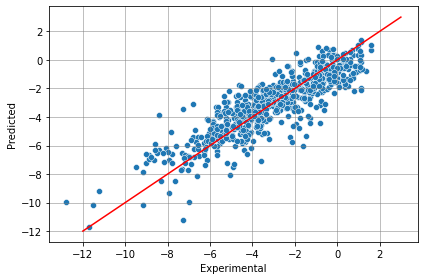

In [20]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('olscvpred.jpg', format='jpeg', dpi=400)
plt.show()

**Residual-plot for linearity check**

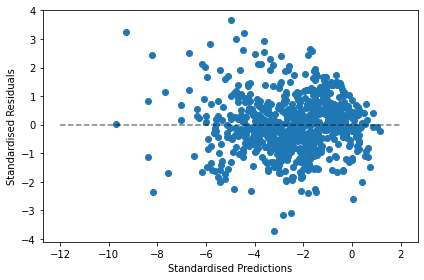

In [21]:
res = np.array(ytrn - ypred)
res_scaler = StandardScaler()
res_sc = res_scaler.fit_transform(res.reshape(-1,1))
ypred_sc = res_scaler.transform(ypred.reshape(-1,1))


import matplotlib.pyplot as plt

plt.scatter(x=ypred_sc,y=res_sc)
plt.xlabel('Standardised Predictions')
plt.ylabel('Standardised Residuals')
sns.lineplot(y=0,x=np.linspace(-12,2,50),linestyle="dashed", color='black', alpha=0.5)
plt.tight_layout()
plt.savefig('olsresplotcv.jpg', format='jpeg', dpi=400)
plt.show()

## TEST

In [22]:
lin_reg.fit(xtrn, ytrn.values)

# Predictions
ypred_tst = lin_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst, test=True)

val_perf = pd.DataFrame([scores], index=['MLR'])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222


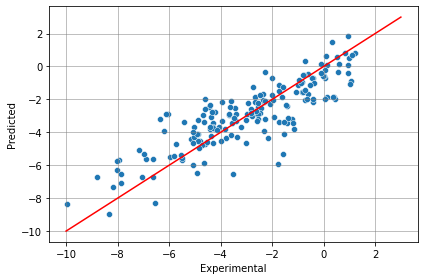

In [23]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('olststpred.jpg', format='jpeg', dpi=400)
plt.show()


**Residual plot for linearity check**

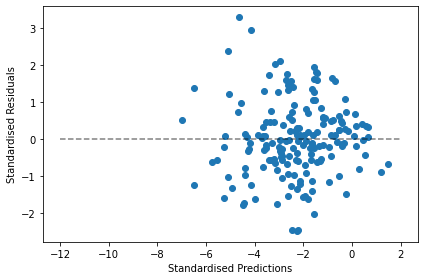

In [24]:
res = np.array(ytst - ypred_tst)
res_scaler = StandardScaler()
res_sc = res_scaler.fit_transform(res.reshape(-1,1))
ypred_tst_sc = res_scaler.transform(ypred_tst.reshape(-1,1))

import matplotlib.pyplot as plt

plt.scatter(x=ypred_tst_sc,y=res_sc)
plt.xlabel('Standardised Predictions')
plt.ylabel('Standardised Residuals')
sns.lineplot(y=0,x=np.linspace(-12,2,50),linestyle="dashed", color='black', alpha=0.5)
plt.tight_layout()
plt.savefig('olsresplottst.jpg', format='jpeg', dpi=400)
plt.show()

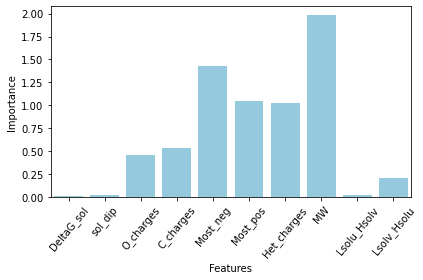

In [25]:
features = ftrs.columns
importance = lin_reg.coef_
ftrs_imp_map=dict(zip(features, importance))
ftrs_imp_map_desc = {k: v for k, v in sorted(ftrs_imp_map.items(), key=lambda item: item[1],reverse=True)}

# Effect of Absolute of coefficients on the model (to make more interpretable)
sns.barplot(features, np.abs(importance), color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=50)
plt.tight_layout()
plt.savefig('olsftrsimp.jpg', format='jpeg', dpi=400)
plt.show()

In [26]:
len(lin_reg.coef_)
len(ftrs.columns)
for f,c in ftrs_imp_map.items():
    print(f'{f}: {c}')

DeltaG_sol: -0.0129399571061557
sol_dip: 0.02105407910034851
O_charges: -0.4562451326228269
C_charges: -0.5307850286412139
Most_neg: -1.425110968290607
Most_pos: -1.050597256808902
Het_charges: -1.0214849711679426
MW: -1.9796430782805234
Lsolu_Hsolv: -0.020674697955690664
Lsolv_Hsolu: 0.2080214291961616


# Ridge Regression 

Lets see how it performs without hyperparameter tuning

In [27]:
# Without Optimisation
rid_reg = Ridge()

# CV
cv = KFold(10)
ypred = cross_val_predict(rid_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['Ridge'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
Ridge,1.210608,0.758331,47.777778,64.305556


**Optimisation**

In [28]:
# # With Optimisation
# # Alpha values to check
# parameters = {'alpha':np.arange(0,1,0.01)}

# # prepare the model (RMSE scores)
# rid_reg= GridSearchCV(rid_reg, parameters, scoring='neg_mean_squared_error',cv=10)
# rid_reg.fit(xtrn, ytrn.values)

# # best model
# rid_reg = rid_reg.best_estimator_
# rid_reg

rid_reg = Ridge(alpha=0.99)

## CV

In [29]:
model = make_pipeline(StandardScaler(), rid_reg)
cv = KFold(10)
ypred = cross_val_predict(model, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['RR'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556


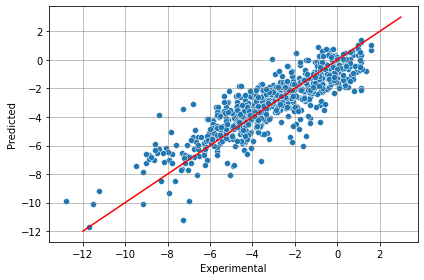

In [30]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('rrcvpred.jpg', format='jpeg', dpi=400)
plt.show()

## VAL

In [31]:
rid_reg.fit(xtrn, ytrn.values)

# Predictions
ypred_tst = rid_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst, test=True)

scores = pd.DataFrame(scores, index=['RR'])

val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222


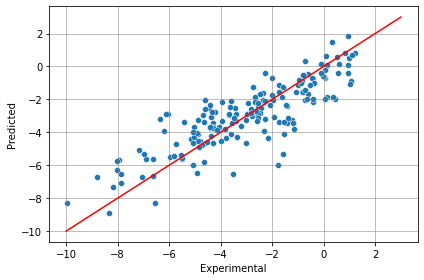

In [32]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('rrtstpred.jpg', format='jpeg', dpi=400)
plt.show()

In [33]:
len(rid_reg.coef_)
len(ftrs.columns)
for f,c in ftrs_imp_map.items():
    print(f'{f}: {c}')

DeltaG_sol: -0.0129399571061557
sol_dip: 0.02105407910034851
O_charges: -0.4562451326228269
C_charges: -0.5307850286412139
Most_neg: -1.425110968290607
Most_pos: -1.050597256808902
Het_charges: -1.0214849711679426
MW: -1.9796430782805234
Lsolu_Hsolv: -0.020674697955690664
Lsolv_Hsolu: 0.2080214291961616


# Lasso Regression

In [34]:
# Without Optimisation
las_reg = Lasso()

# CV
cv = KFold(10)
ypred = cross_val_predict(las_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['Lasso'])

scores


,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
Lasso,2.131442,0.41273,24.305556,32.361111


In [35]:
# # With Optimisation
# # Alpha values to check
# parameters = {'alpha':np.arange(0.01,1,0.01)}

# # prepare the model (RMSE scores)
# las_reg= GridSearchCV(las_reg, parameters, scoring='neg_mean_squared_error',cv=10)
# las_reg.fit(xtrn, ytrn.values)

# las_reg = las_reg.best_estimator_

las_reg = Lasso(alpha=0.01)


## CV

In [36]:
model = make_pipeline(StandardScaler(), las_reg)
cv = KFold(10)
ypred = cross_val_predict(model, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['Lasso'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000


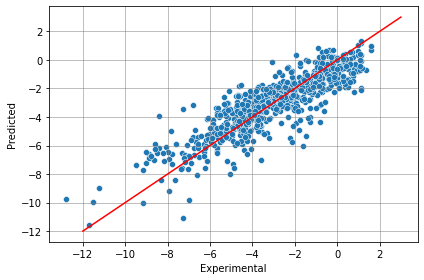

In [37]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('larcvpred.jpg', format='jpeg', dpi=400)
plt.show()

## VAL

In [38]:
las_reg.fit(xtrn, ytrn.values)

# Predictions
ypred_tst = las_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst, test=True)

scores = pd.DataFrame(scores, index=['Lasso'])

val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222


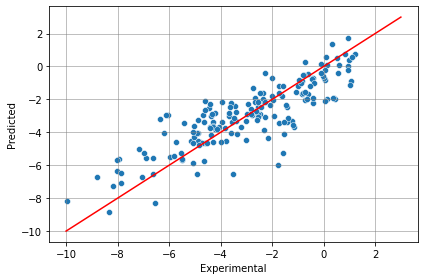

In [39]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('lartstpred.jpg', format='jpeg', dpi=400)
plt.show()

Some thoughts, on why such performance:

LASSO works better when you have more features (because some of them will be driven to zero when contributing to the model) and you need to make a simpler and more interpretable model. Ridge Regression works better when you have less features, but otherwise, in most cases, should be avoided due to higher complexity and lower interpretability(which is really important for practical data evaluation).

Both methods allow to use correlated predictors, but they solve multicollinearity issue differently:
In ridge regression, the coefficients of correlated predictors are similar;
In lasso, one of the correlated predictors has a larger coefficient, while the rest are (nearly) zeroed.

# SVR (Support Vector Regression) - Linear

In [40]:
# Without Optimisation - Simple Linear SVR
svm_reg = svm.LinearSVR(max_iter=18000)

cv = KFold(10)
ypred = cross_val_predict(svm_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['SVR'])

# cv_perf = cv_perf.append([scores])
# cv_perf
scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
SVR,1.212343,0.757096,48.472222,63.472222


In [41]:
# # With Optimisation
# parameters = {'epsilon':np.arange(0.01, 1, 0.01)} #,'C':[0.01, 0.2, 0.5, 1, 3, 10, 15]}

# # Not including 'C' yet as for linear, regularisation will cause similar changes as what 'epsilon' will cause

# # prepare the model (RMSE scores)
# svm_reg= GridSearchCV(svm_reg, parameters, scoring='neg_mean_squared_error',cv=10)
# svm_reg.fit(xtrn, ytrn.values)

# svm_reg = svm_reg.best_estimator_
svm_reg = svm.LinearSVR(epsilon=0.52, max_iter=18000)


## CV

In [42]:
cv = KFold(10)
ypred = cross_val_predict(svm_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['SVR'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000
SVR,1.209062,0.759164,48.333333,63.333333


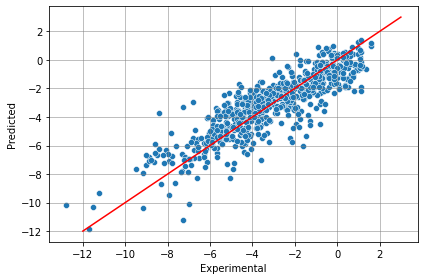

In [43]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('svrcvpred.jpg', format='jpeg', dpi=400)
plt.show()

## VAL

In [44]:
svm_reg.fit(xtrn, ytrn.values)

# Predictions
ypred_tst = svm_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst, test=True)

scores = pd.DataFrame(scores, index=['SVR'])

val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222
SVR,1.286681,0.713185,50.555556,62.222222


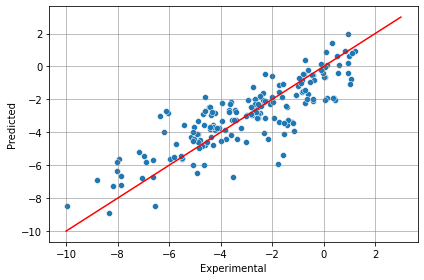

In [45]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('svrtstpred.jpg', format='jpeg', dpi=400)
plt.show()

# SVR (Support Vector Regression) - Non-Linear/Kernel based

In [46]:
# Without Optimisation performance
ksvm_reg=svm.SVR()

ypred = cross_val_predict(ksvm_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['kSVR'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
kSVR,1.091,0.806283,58.75,72.777778


In [47]:
# %%time
# # Directly going for the best
# # With Optimisation
parameters = {'C': [0.5, 1, 5], 'epsilon': [0.01, 0.069, 1], 'gamma': [0.0909,0.001, 0.01], 'kernel': ['rbf']}

# # prepare the model (RMSE scores)
# model = svm.SVR()
# ksvm_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=5, n_jobs=-1) # n_jobs=-1 (uses all cpus)
# ksvm_reg.fit(xtrn, ytrn.values)

# ksvm_reg = ksvm_reg.best_estimator_
# ksvm_reg
# ksvm_reg=svm.SVR(kernel='rbf',C=13, epsilon=0.1, gamma=0.03)
# ksvm_reg = svm.SVR(C=5, degree=2, epsilon=0.069, gamma=0.08)
ksvm_reg = svm.SVR(C=5, epsilon=0.069, gamma=0.0909)

## CV

In [48]:
ypred = cross_val_predict(ksvm_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['kSVR'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000
SVR,1.209062,0.759164,48.333333,63.333333
kSVR,1.009226,0.831617,62.777778,76.666667


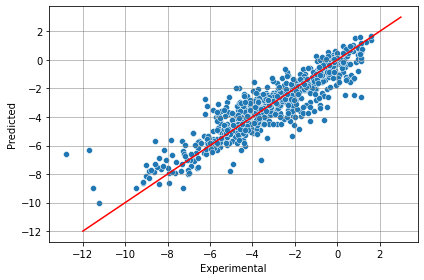

In [49]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('ksvrcvpred.jpg', format='jpeg', dpi=400)
plt.show()

## VAL

In [50]:
ksvm_reg.fit(xtrn, ytrn.values)

# Predictions
ypred_tst = ksvm_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst, test=True)

scores = pd.DataFrame(scores, index=['kSVR'])

val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222
SVR,1.286681,0.713185,50.555556,62.222222
kSVR,1.103858,0.793697,56.666667,70.000000


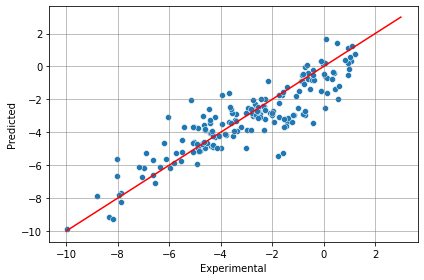

In [51]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('ksvrtstpred.jpg', format='jpeg', dpi=400)
plt.show()

# RandomForest

In [52]:
# Without Optimisation performance (G_sol removed)
forest_reg=RandomForestRegressor(random_state=20)

ypred = cross_val_predict(forest_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['RF'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
RF,1.001443,0.835053,60.277778,75.138889


In [53]:
# Without Optimisation performance
forest_reg=RandomForestRegressor(random_state=20)

ypred = cross_val_predict(forest_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['RF'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
RF,1.001443,0.835053,60.277778,75.138889


In [54]:
# %%time
# forest_reg=RandomForestRegressor(random_state=20)

# # Parameters tuning to get the best Random forest model
# n_estimators = [100,200,300,400,500]
# max_depth = [10,50,100, 200]
# max_features = np.arange(1,13,1)

# parameters = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#              'max_features': max_features}

# grid = GridSearchCV(forest_reg, param_grid=parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid.fit(xtrn, np.ravel(ytrn.values))

# forest_reg = grid.best_estimator_
# forest_reg
forest_reg = RandomForestRegressor(max_depth=50, max_features=8, n_estimators=500,
                      random_state=20)

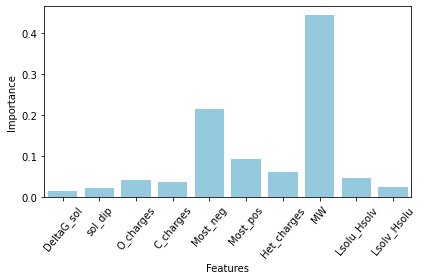

In [55]:
forest_reg.fit(xtrn,ytrn)

features = ftrs.columns
importance = forest_reg.feature_importances_
ftrs_imp_map=dict(zip(features, importance))
ftrs_imp_map_desc = {k: v for k, v in sorted(ftrs_imp_map.items(), key=lambda item: item[1],reverse=True)}

# Effect of Absolute of coefficients on the model (to make more interpretable)
sns.barplot(features, importance, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=50)
plt.tight_layout()
plt.savefig('rfftrsimp.jpg', format='jpeg', dpi=400)
plt.show()

# CV

In [56]:
cv = KFold(10)
ypred = cross_val_predict(forest_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['RF'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000
SVR,1.209062,0.759164,48.333333,63.333333
kSVR,1.009226,0.831617,62.777778,76.666667
RF,0.985643,0.841300,59.861111,76.666667


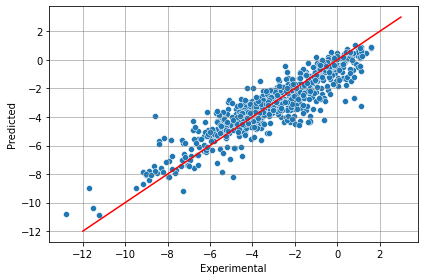

In [57]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('rfcvpred.jpg', format='jpeg', dpi=400)
plt.show()

# VAL

In [58]:
forest_reg.fit(xtrn, ytrn.values)

# Predictions
ypred_tst = forest_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst, test=True)

scores = pd.DataFrame(scores, index=['RF'])

val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222
SVR,1.286681,0.713185,50.555556,62.222222
kSVR,1.103858,0.793697,56.666667,70.000000
RF,1.069252,0.807511,58.333333,71.111111


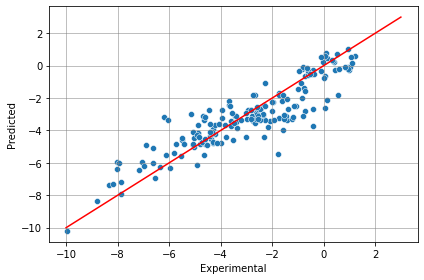

In [59]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('rftstpred.jpg', format='jpeg', dpi=400)
plt.show()

# Extra Trees (ET)

In [60]:
# Without Optimisation performance (G_sol removed)
et_reg=ExtraTreesRegressor(random_state=20, n_jobs=-1)

ypred = cross_val_predict(et_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['ET'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
ET,0.939466,0.854495,63.888889,78.055556


**For G_sol and volume removed use without opt. 
gives better performance**

In [61]:
# Without Optimisation performance
et_reg=ExtraTreesRegressor(random_state=20, n_jobs=-1)

ypred = cross_val_predict(et_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['ET'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
ET,0.939466,0.854495,63.888889,78.055556


In [62]:
# %%time
# # With Optimisation
# et_reg=ExtraTreesRegressor(random_state=20, n_jobs=-1)

# # # Parameters tuning to get the best Random forest model
# n_estimators = [100,200,300,400,500]
# max_depth = [10,50,100, 200]
# max_features = np.arange(1,13,1)

# parameters = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#              'max_features': max_features}

# grid = GridSearchCV(et_reg, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
# grid.fit(xtrn, np.ravel(ytrn.values))

# et_reg = grid.best_estimator_
# et_reg
et_reg = ExtraTreesRegressor(max_depth=100, max_features=8, n_estimators=400, n_jobs=-1,
                    random_state=20)

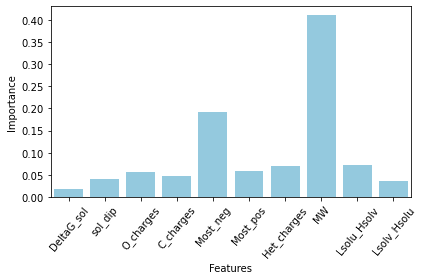

In [63]:
et_reg.fit(xtrn,ytrn)

features = ftrs.columns
importance = et_reg.feature_importances_

ftrs_imp_map=dict(zip(features, importance))
ftrs_imp_map_desc = {k: v for k, v in sorted(ftrs_imp_map.items(), key=lambda item: item[1],reverse=True)}

# Effect of Absolute of coefficients on the model (to make more interpretable)
sns.barplot(features, importance, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=50)
plt.tight_layout()
plt.savefig('etftrsimp.jpg', format='jpeg', dpi=400)
plt.show()

# CV

In [64]:
cv = KFold(10)
ypred = cross_val_predict(et_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['ET'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000
SVR,1.209062,0.759164,48.333333,63.333333
kSVR,1.009226,0.831617,62.777778,76.666667
RF,0.985643,0.841300,59.861111,76.666667
ET,0.927780,0.859280,64.166667,78.611111


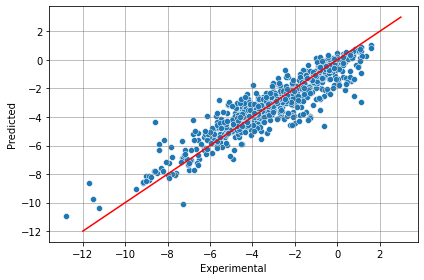

In [65]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('etcvpred.jpg', format='jpeg', dpi=400)
plt.show()

ET seems to be performing better than even RF... 

# VAL

In [66]:
et_reg.fit(xtrn, ytrn.values)

# Predictions
ypred_tst = et_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst,test=True)

scores = pd.DataFrame(scores, index=['ET'])

val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222
SVR,1.286681,0.713185,50.555556,62.222222
kSVR,1.103858,0.793697,56.666667,70.000000
RF,1.069252,0.807511,58.333333,71.111111
ET,1.003911,0.832813,58.333333,72.777778


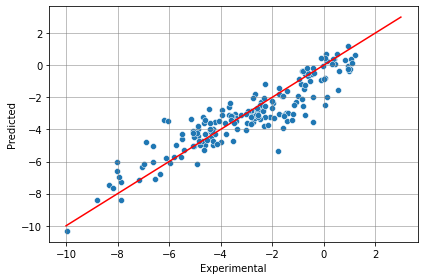

In [67]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('ettstpred.jpg', format='jpeg', dpi=400)
plt.show()

# Principal component regression (PCR)

In [68]:
pca = PCA()
xtrn_red = pca.fit_transform(xtrn)

In [69]:
pca.explained_variance_ratio_

array([0.39358642, 0.17647244, 0.15329193, 0.09980005, 0.0652821 ,
       0.0415949 , 0.0357541 , 0.0213874 , 0.00750849, 0.00532217])

In [70]:
sum=0
for i,var in enumerate(pca.explained_variance_ratio_):
    if sum>=0.95:
        print(i)
        break
    sum+=var


7


This shows that first component explain 95%+ of data.
We can just suffice with using 7 features instead of all in that case.

In [71]:
# fitting a linear reg over 7 components
pca_reg = LinearRegression()
comp_scores = pd.DataFrame()

cv = KFold(10)
ypred = cross_val_predict(pca_reg, xtrn_red[:,:7], ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['PCR-7components'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
PCR-7components,1.386267,0.683231,39.027778,54.444444


In [72]:
cv = KFold(10)
ypred = cross_val_predict(pca_reg, xtrn_red[:,:1], ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn_red[:,:1],ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn_red[:,:1],ytrn)]

component_scores = get_scores(trgt_f, ypred_f)
component_scores = pd.DataFrame(component_scores, index=[str(1)])

scores_list=[]
for i in np.arange(2,12):
    # Cross-validation results
    cv = KFold(10)
    ypred = cross_val_predict(pca_reg, xtrn_red[:,:i], ytrn, cv=cv)
    ypred_f = [ypred[j] for i, j in cv.split(xtrn_red[:,:i],ytrn)]
    trgt_f = [ytrn[j] for i, j in cv.split(xtrn_red[:,:i],ytrn)]
    scores = get_scores(trgt_f, ypred_f)
    scores = pd.DataFrame(scores, index=[str(i)])
    component_scores = component_scores.append(scores)

In [73]:
component_scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
1,2.443509,0.007468,18.888889,27.361111
2,2.233050,0.177394,22.361111,28.750000
3,1.835628,0.438107,34.027778,45.833333
4,1.838625,0.436321,33.472222,45.833333
5,1.470120,0.637440,38.472222,53.611111
6,1.451590,0.647009,38.055556,54.444444
7,1.386267,0.683231,39.027778,54.444444
8,1.308739,0.718817,43.333333,59.305556
9,1.220761,0.754742,48.194444,62.500000
10,1.210683,0.758306,48.055556,63.611111


In [74]:
display(component_scores[component_scores['RMSE']==component_scores['RMSE'].min()])
print('Min RMSE')

display(component_scores[component_scores['Pearson-rsquare']==component_scores['Pearson-rsquare'].max()])
print('Max R2')

display(component_scores[component_scores['%P±0.7']==component_scores['%P±0.7'].max()])
print('Max %LogS±0.7')

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
10,1.210683,0.758306,48.055556,63.611111
11,1.210683,0.758306,48.055556,63.611111


Min RMSE


,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
10,1.210683,0.758306,48.055556,63.611111
11,1.210683,0.758306,48.055556,63.611111


Max R2


,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
9,1.220761,0.754742,48.194444,62.5


Max %LogS±0.7


This is interesting what we found above. This is a proof that PCR only considers variance of the independent variables and not the relationship with the target variable. 

As can be seen, When we include all the principal components the number of components which performed the best are 10 (Based on the %LogS±0.7 metric) and it is 12 (Based on the RMSE metric, which is usually the norm for taking such decisions). 

**Therefore, We conclude with n_components=10 and record the performance for Cross-Validation and Validation test**

## CV

In [75]:
pca = PCA(n_components=9)
xtrn_red = pca.fit_transform(xtrn)
pca_reg = LinearRegression()

cv = KFold(10)
ypred = cross_val_predict(pca_reg, xtrn_red, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn_red,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn_red,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['PCR'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000
SVR,1.209062,0.759164,48.333333,63.333333
kSVR,1.009226,0.831617,62.777778,76.666667
RF,0.985643,0.841300,59.861111,76.666667
ET,0.927780,0.859280,64.166667,78.611111
PCR,1.220761,0.754742,48.194444,62.500000


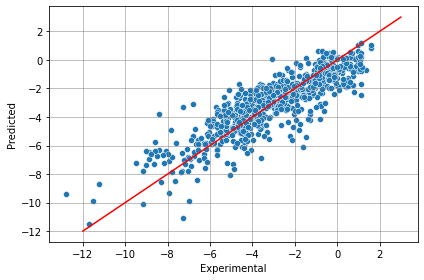

In [76]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('pcrcvpred.jpg', format='jpeg', dpi=400)
plt.show()

## VAL

In [77]:
pca_reg.fit(xtrn_red, ytrn.values)

# Predictions
# PCA Transformation for the Test set 
xtst_red = pca.transform(xtst)

ypred_tst = pca_reg.predict(xtst_red)

scores = get_scores(ytst, ypred_tst, test=True)

scores = pd.DataFrame(scores, index=['PCR'])
val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222
SVR,1.286681,0.713185,50.555556,62.222222
kSVR,1.103858,0.793697,56.666667,70.000000
RF,1.069252,0.807511,58.333333,71.111111
ET,1.003911,0.832813,58.333333,72.777778
PCR,1.296344,0.708884,46.666667,63.333333


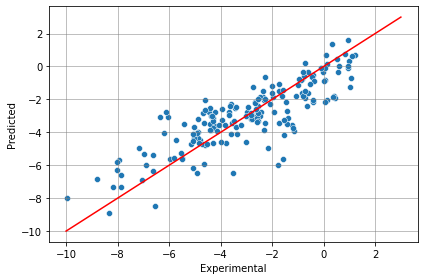

In [78]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('pcrtstpred.jpg', format='jpeg', dpi=400)
plt.show()

**Overall, the model did'nt seem to perform very well**

# Partial least Squares (PLS)

In [79]:
# Getting the best number of components
pls_reg = PLSRegression(n_components=1)

cv = KFold(10)
ypred = cross_val_predict(pls_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn_red[:,:1],ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn_red[:,:1],ytrn)]

component_scores = get_scores(trgt_f, ypred_f)
component_scores = pd.DataFrame(component_scores, index=[str(1)])

scores_list=[]
for i in np.arange(2,12):
    # Cross-validation results
    pls_reg = PLSRegression(n_components=i)
    cv = KFold(10)
    ypred = cross_val_predict(pls_reg, xtrn, ytrn, cv=cv)
    ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
    trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]
    scores = get_scores(trgt_f, ypred_f)
    scores = pd.DataFrame(scores, index=[str(i)])
    component_scores = component_scores.append(scores)
component_scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
1,1.547935,0.597929,41.250000,53.888889
2,1.373505,0.686007,43.750000,61.805556
3,1.307785,0.717674,42.083333,56.111111
4,1.279609,0.729582,44.861111,58.611111
5,1.241703,0.747264,45.833333,62.361111
6,1.220575,0.754448,47.083333,62.500000
7,1.209417,0.758755,47.222222,62.916667
8,1.210363,0.758501,48.055556,63.472222
9,1.210599,0.758347,47.500000,63.333333
10,1.210683,0.758306,48.055556,63.611111


In [80]:
display(component_scores[component_scores['RMSE']==component_scores['RMSE'].min()])
print('Min RMSE')

display(component_scores[component_scores['Pearson-rsquare']==component_scores['Pearson-rsquare'].max()])
print('Max R2')

display(component_scores[component_scores['%P±0.7']==component_scores['%P±0.7'].max()])
print('Max %LogS±0.7')

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
7,1.209417,0.758755,47.222222,62.916667


Min RMSE


,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
7,1.209417,0.758755,47.222222,62.916667


Max R2


,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
8,1.210363,0.758501,48.055556,63.472222


Max %LogS±0.7


**Conclusion:**
Amazing! the number of components/directions (which is nothing but the linear combination of all the inputs based on variance explained and relation with target) with best performance (Based on %LogS±0.7) is 7 and 9. from among 7 and 9 we should consider 9 as the r2-score is higher and RMSE is lower.

Therefore, I will finalise n_components = 7

## CV

In [81]:
# Getting the best number of components
pls_reg = PLSRegression(n_components=8)

cv = KFold(10)
ypred = cross_val_predict(pls_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn_red[:,:1],ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn_red[:,:1],ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['PLS'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000
SVR,1.209062,0.759164,48.333333,63.333333
kSVR,1.009226,0.831617,62.777778,76.666667
RF,0.985643,0.841300,59.861111,76.666667
ET,0.927780,0.859280,64.166667,78.611111
PCR,1.220761,0.754742,48.194444,62.500000
PLS,1.210363,0.758501,48.055556,63.472222


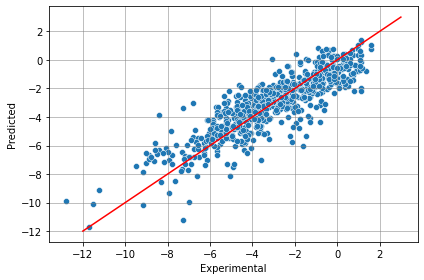

In [82]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred.reshape(720))
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('plscvpred.jpg', format='jpeg', dpi=400)
plt.show()

## VAL

In [83]:
pls_reg.fit(xtrn, ytrn.values)

# Predictions
# PCA Transformation for the Test set 

ypred_tst = pls_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst, test=True)

scores = pd.DataFrame(scores, index=['PLS'])
val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222
SVR,1.286681,0.713185,50.555556,62.222222
kSVR,1.103858,0.793697,56.666667,70.000000
RF,1.069252,0.807511,58.333333,71.111111
ET,1.003911,0.832813,58.333333,72.777778
PCR,1.296344,0.708884,46.666667,63.333333
PLS,1.280032,0.716295,48.333333,62.222222


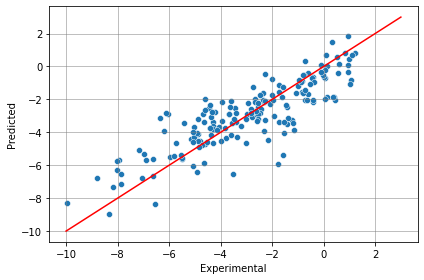

In [84]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst.reshape(180))
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('plststpred.jpg', format='jpeg', dpi=400)
plt.show()

# GP (Gaussian Processes)

**Finding best Hyperparamets using Cross-validation**

In [85]:
import GPy
kernel = GPy.kern.RBF(variance=1, lengthscale=1, input_dim=12)
model = GPy.models.GPRegression(xtrn, ytrn.values.reshape(-1,1), noise_var=1)
model.optimize()

model

GP_regression.,value,constraints,priors
rbf.variance,16.41210201282298,+ve,
rbf.lengthscale,3.3733812773076695,+ve,
Gaussian_noise.variance,0.6424917796475939,+ve,


## CV

In [86]:
var = 15.14667434331025
lsc = 3.7800330643709446
noise_var = 0.6335463958981256

ypreds_l = []

kf = KFold(10)
xtrn_splits = kf.get_n_splits(xtrn)
splits = kf.split(xtrn, ytrn)
k=1
for i,j in splits:
    print(f'Fold: {k}')
    xtst0 = xtrn[j]
    ytst0 = ytrn[j]
    
    xtrn0 = np.array([xtrn[i] for i in range(len(xtrn)) if i not in j])
    ytrn0 = np.array([ytrn[i] for i in range(len(ytrn)) if i not in j])
    
    kernel = GPy.kern.RBF(variance=var, lengthscale=lsc, input_dim=12)
    model = GPy.models.GPRegression(xtrn0, ytrn0.reshape(-1,1), noise_var=noise_var)
    model.optimize()
    
    ypreds=model.predict(xtst0)[0]
    ypreds
    ypreds_l.append(ypreds)
            
    k+=1

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10


In [87]:
# Getting the best number of components
cv = KFold(10)
ypred_f = ypreds_l
trgt_f = [ytrn[j] for i, j in kf.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['GP'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000
SVR,1.209062,0.759164,48.333333,63.333333
kSVR,1.009226,0.831617,62.777778,76.666667
RF,0.985643,0.841300,59.861111,76.666667
ET,0.927780,0.859280,64.166667,78.611111
PCR,1.220761,0.754742,48.194444,62.500000
PLS,1.210363,0.758501,48.055556,63.472222
GP,0.989106,0.838910,61.111111,77.361111


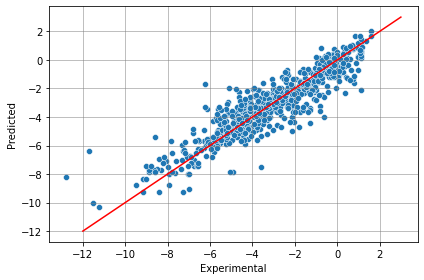

In [88]:
# Getting predictions in one array
ypred=[]
for i in ypred_f:
    for j in i:
        ypred.append(j)
ypred=np.array(ypred).reshape(720)

# Plot
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred)
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('gpcvpred.jpg', format='jpeg', dpi=400)
plt.show()

## VAL

In [89]:
var = 15.14667434331025
lsc = 3.7800330643709446
noise_var = 0.6335463958981256

kernel = GPy.kern.RBF(variance=var, lengthscale=lsc, input_dim=12)
model = GPy.models.GPRegression(xtrn, ytrn.values.reshape(-1,1), noise_var=noise_var)
model.optimize()

ypred_tst=model.predict(xtst)[0]

scores = get_scores(ytst, ypred_tst, test=True)
scores = pd.DataFrame(scores, index=['GP'])
val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222
SVR,1.286681,0.713185,50.555556,62.222222
kSVR,1.103858,0.793697,56.666667,70.000000
RF,1.069252,0.807511,58.333333,71.111111
ET,1.003911,0.832813,58.333333,72.777778
PCR,1.296344,0.708884,46.666667,63.333333
PLS,1.280032,0.716295,48.333333,62.222222
GP,1.090043,0.799711,55.000000,70.000000


In [90]:
model

GP_regression.,value,constraints,priors
rbf.variance,16.418735753700584,+ve,
rbf.lengthscale,3.3733535100038026,+ve,
Gaussian_noise.variance,0.6424669383131518,+ve,


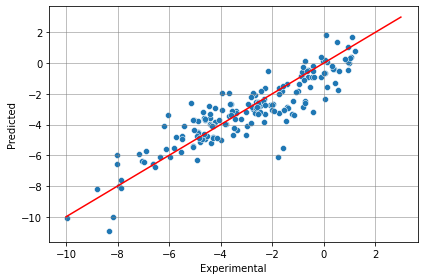

In [91]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst.reshape(180))
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('gptstpred.jpg', format='jpeg', dpi=400)
plt.show()

# Bagging of DTs (Not RF)

**A Bagging of decision-trees** 
Sounds similar to RF but has difference in the way bootstrap samples are made between the two. Refer to notes.

In [92]:
# Without Optimisation performance (G_sol removed)
bag_reg=BaggingRegressor(random_state=20, n_jobs=-1)

cv=KFold(10)
ypred = cross_val_predict(bag_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['BAG'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
BAG,1.060934,0.814398,57.916667,73.194444


**Use nguyen group params for bagging as it performs better**

In [93]:
# Nguyen group
bag_reg=BaggingRegressor(n_estimators=500)

In [94]:
# %%time

# bag_reg=BaggingRegressor(random_state=20)

# # Parameters tuning to get the best Bagging Regression model
# n_estimators = [100,200,300,400,500]
# max_samples = [10,50,100, 200,400,500]

# parameters = {'n_estimators': n_estimators,
#               'max_samples': max_samples}

# grid = GridSearchCV(bag_reg, param_grid=parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid.fit(xtrn, np.ravel(ytrn.values))

# bag_reg = grid.best_estimator_
# bag_reg

# bag_reg = BaggingRegressor(max_samples=500, n_estimators=500, n_jobs=-1, random_state=20)

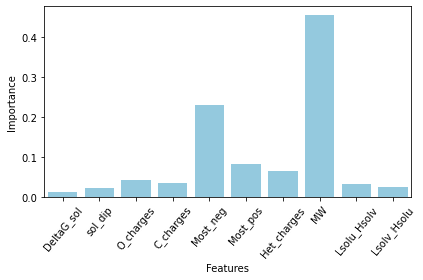

In [95]:
bag_reg.fit(xtrn, ytrn.values)
feature_importances = np.mean([
    tree.feature_importances_ for tree in bag_reg.estimators_
], axis=0)

features = ftrs.columns
importance = feature_importances
ftrs_imp_map=dict(zip(features, importance))
ftrs_imp_map_desc = {k: v for k, v in sorted(ftrs_imp_map.items(), key=lambda item: item[1],reverse=True)}

# Effect of Absolute of coefficients on the model (to make more interpretable)
sns.barplot(features, importance, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=50)
plt.tight_layout()
plt.savefig('bagftrsimp.jpg', format='jpeg', dpi=400)
plt.show()

## CV

In [96]:
# Cross-validation results
cv=KFold(10)
ypred = cross_val_predict(bag_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['Bag'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000
SVR,1.209062,0.759164,48.333333,63.333333
kSVR,1.009226,0.831617,62.777778,76.666667
RF,0.985643,0.841300,59.861111,76.666667
ET,0.927780,0.859280,64.166667,78.611111
PCR,1.220761,0.754742,48.194444,62.500000
PLS,1.210363,0.758501,48.055556,63.472222
GP,0.989106,0.838910,61.111111,77.361111


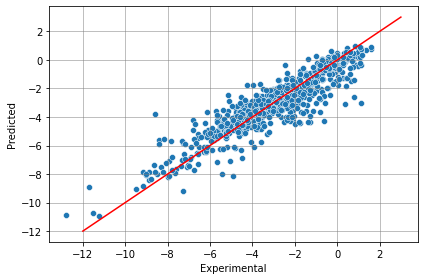

In [97]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred.reshape(720))
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('bagcvpred.jpg', format='jpeg', dpi=400)
plt.show()

## VAL

In [98]:
bag_reg.fit(xtrn, ytrn.values)

# Predictions
ypred_tst = bag_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst, test=True)

scores = pd.DataFrame(scores, index=['Bag'])

val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222
SVR,1.286681,0.713185,50.555556,62.222222
kSVR,1.103858,0.793697,56.666667,70.000000
RF,1.069252,0.807511,58.333333,71.111111
ET,1.003911,0.832813,58.333333,72.777778
PCR,1.296344,0.708884,46.666667,63.333333
PLS,1.280032,0.716295,48.333333,62.222222
GP,1.090043,0.799711,55.000000,70.000000


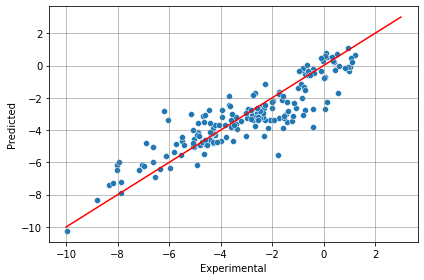

In [99]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst.reshape(180))
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('bagtstpred.jpg', format='jpeg', dpi=400)
plt.show()

# Adaptive Boosting (AdaBoost)

In [100]:
# Without Optimisation performance (G_sol removed)
base_estimator = DecisionTreeRegressor(max_depth=5)
adab_reg = AdaBoostRegressor(base_estimator=base_estimator,random_state=20)

cv=KFold(10)
ypred = cross_val_predict(adab_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['ADAB'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
ADAB,1.033824,0.826585,55.694444,69.861111


In [101]:
# Without Optimisation performance
base_estimator = DecisionTreeRegressor(max_depth=5)
adab_reg = AdaBoostRegressor(base_estimator=base_estimator,random_state=20)

cv=KFold(10)
ypred = cross_val_predict(adab_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['ADAB'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
ADAB,1.033824,0.826585,55.694444,69.861111


In [102]:
# %%time

# base_estimator = DecisionTreeRegressor(max_depth=5)
# adab_reg = AdaBoostRegressor(base_estimator=base_estimator,random_state=20)

# # Parameters tuning to get the best Bagging Regression model
# n_estimators = [100,200,300,400,500,700,1000]
# learning_rate = [0.0001, 0.001, 0.01, 0.1, 1.0]

# parameters = {'n_estimators': n_estimators,
#               'learning_rate': learning_rate}

# grid = GridSearchCV(adab_reg, param_grid=parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid.fit(xtrn, np.ravel(ytrn.values))

# adab_reg = grid.best_estimator_
# adab_reg

adab_reg=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),n_estimators=200, random_state=20)   

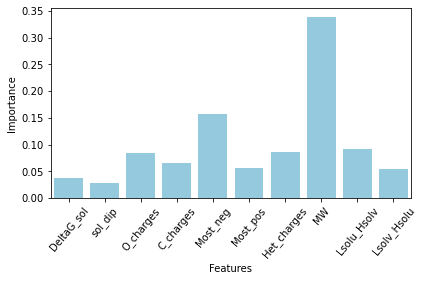

In [103]:
adab_reg.fit(xtrn, ytrn)
feature_importances = adab_reg.feature_importances_

features = ftrs.columns
importance = feature_importances
ftrs_imp_map=dict(zip(features, importance))
ftrs_imp_map_desc = {k: v for k, v in sorted(ftrs_imp_map.items(), key=lambda item: item[1],reverse=True)}

# Effect of Absolute of coefficients on the model (to make more interpretable)
sns.barplot(features, importance, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=50)
plt.tight_layout()
plt.savefig('adabftrsimp.jpg', format='jpeg', dpi=400)
plt.show()

## CV

In [104]:
cv = KFold(10)

ypred = cross_val_predict(adab_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['ADAB'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000
SVR,1.209062,0.759164,48.333333,63.333333
kSVR,1.009226,0.831617,62.777778,76.666667
RF,0.985643,0.841300,59.861111,76.666667
ET,0.927780,0.859280,64.166667,78.611111
PCR,1.220761,0.754742,48.194444,62.500000
PLS,1.210363,0.758501,48.055556,63.472222
GP,0.989106,0.838910,61.111111,77.361111


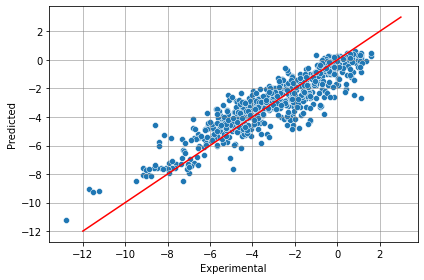

In [105]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred.reshape(720))
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('adabcvpred.jpg', format='jpeg', dpi=400)
plt.show()

## VAL

In [106]:
adab_reg.fit(xtrn, ytrn.values)

# Predictions
ypred_tst = adab_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst,test=True)

scores = pd.DataFrame(scores, index=['ADAB'])

val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222
SVR,1.286681,0.713185,50.555556,62.222222
kSVR,1.103858,0.793697,56.666667,70.000000
RF,1.069252,0.807511,58.333333,71.111111
ET,1.003911,0.832813,58.333333,72.777778
PCR,1.296344,0.708884,46.666667,63.333333
PLS,1.280032,0.716295,48.333333,62.222222
GP,1.090043,0.799711,55.000000,70.000000


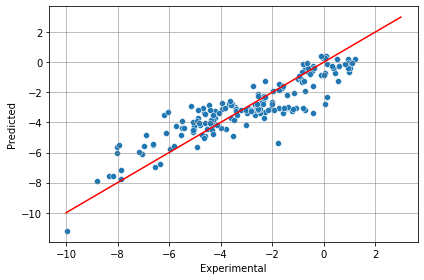

In [107]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst.reshape(180))
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('adabtstpred.jpg', format='jpeg', dpi=400)
plt.show()

# Gradient Boosting

In [108]:
# Without Optimisation performance
gradb_reg = GradientBoostingRegressor(random_state=20)

cv=KFold(10)
ypred = cross_val_predict(gradb_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['GRADB'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
GRADB,0.97516,0.842623,59.583333,74.305556


In [109]:
# # %%time

# # gradb_reg = GradientBoostingRegressor(random_state=20)

# # # Parameters tuning to get the best Bagging Regression model
# n_estimators = [100,200,300,400,500,700,1000]
# learning_rate = [0.0001, 0.001, 0.01, 0.1, 1.0]
# # subsample = [0.5, 0.7, 1.0]
# max_depth = [3, 7, 9]

# parameters = {'n_estimators': n_estimators,
#               'learning_rate': learning_rate,
# #              'subsample': subsample,
#              'max_depth': max_depth}

# grid = GridSearchCV(gradb_reg, param_grid=parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid.fit(xtrn, np.ravel(ytrn.values))

# gradb_reg = grid.best_estimator_
# gradb_reg
gradb_reg = GradientBoostingRegressor(n_estimators=200, random_state=20)

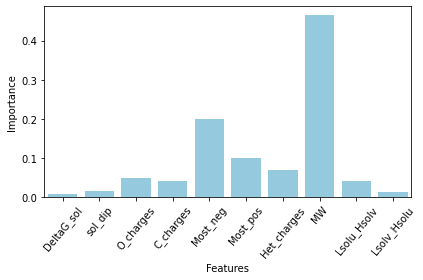

In [110]:
gradb_reg.fit(xtrn, ytrn)
feature_importances = gradb_reg.feature_importances_

features = ftrs.columns
importance = feature_importances
ftrs_imp_map=dict(zip(features, importance))
ftrs_imp_map_desc = {k: v for k, v in sorted(ftrs_imp_map.items(), key=lambda item: item[1],reverse=True)}

# Effect of Absolute of coefficients on the model (to make more interpretable)
sns.barplot(features, importance, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=50)
plt.tight_layout()
plt.savefig('gradbftrsimp.jpg', format='jpeg', dpi=400)
plt.show()

## CV

In [111]:
model = make_pipeline(StandardScaler(), gradb_reg)
cv = KFold(10)
ypred = cross_val_predict(model, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['GRADB'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000
SVR,1.209062,0.759164,48.333333,63.333333
kSVR,1.009226,0.831617,62.777778,76.666667
RF,0.985643,0.841300,59.861111,76.666667
ET,0.927780,0.859280,64.166667,78.611111
PCR,1.220761,0.754742,48.194444,62.500000
PLS,1.210363,0.758501,48.055556,63.472222
GP,0.989106,0.838910,61.111111,77.361111


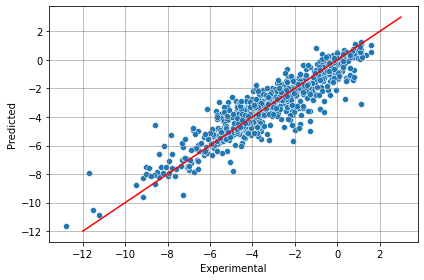

In [112]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred.reshape(720))
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('gradbcvpred.jpg', format='jpeg', dpi=400)
plt.show()

## VAL

In [113]:
gradb_reg.fit(xtrn, ytrn.values)

ypred_tst = gradb_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst, test=True)

scores = pd.DataFrame(scores, index=['GRADB'])

val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222
SVR,1.286681,0.713185,50.555556,62.222222
kSVR,1.103858,0.793697,56.666667,70.000000
RF,1.069252,0.807511,58.333333,71.111111
ET,1.003911,0.832813,58.333333,72.777778
PCR,1.296344,0.708884,46.666667,63.333333
PLS,1.280032,0.716295,48.333333,62.222222
GP,1.090043,0.799711,55.000000,70.000000


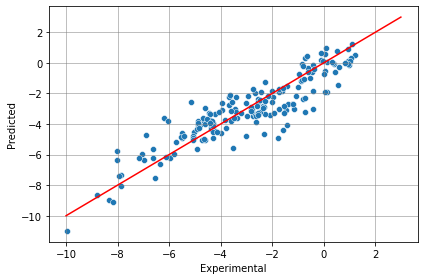

In [114]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst.reshape(180))
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('gradbtstpred.jpg', format='jpeg', dpi=400)
plt.show()

# ANN - MLP Regression

In [115]:
# Shows you how without activation function the model behaves as linear regression
mlp_reg = MLPRegressor(hidden_layer_sizes=190, max_iter=20000, random_state=20,
             solver='sgd', activation='identity')

cv=KFold(10)
ypred = cross_val_predict(mlp_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['MLP'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLP,1.212932,0.757813,47.083333,63.888889


**Actual Work**

In [116]:
# Without any Optimisation and with adam optimiser
mlp_reg = MLPRegressor(random_state=20, max_iter=10000)

cv=KFold(10)
ypred = cross_val_predict(mlp_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['MLP'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLP,0.972122,0.844538,60.0,75.694444


In [117]:
mlp_reg = MLPRegressor(random_state=20, max_iter=10000, solver='sgd')

cv=KFold(10)
ypred = cross_val_predict(mlp_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['MLP'])

scores

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLP,0.978803,0.841024,60.555556,76.111111


**Performance is good even without optimisation**

With SGD it performs much better than with Adam optimiser.

In [118]:
# # # Optimising
# mlp = MLPRegressor(random_state=20, max_iter=20000)

# hidden_layer_sizes = [190, 300, 310, 350, 380, 400, 500]
# activation = ['identity', 'logistic', 'tanh', 'relu']
# solver = ['sgd']
# alpha = [0.0001, 0.001]
# learning_rate_init = [0.001, 0.01]

# parameters = {
#     'hidden_layer_sizes': hidden_layer_sizes,
#     'activation': activation,
#     'solver': solver,
#     'alpha': alpha,
#     'learning_rate_init': learning_rate_init
# }

# grid = GridSearchCV(mlp, param_grid=parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid.fit(xtrn, np.ravel(ytrn.values))

# mlp_reg = grid.best_estimator_
# mlp_reg

mlp_reg = MLPRegressor(hidden_layer_sizes=310, max_iter=20000,random_state=20, solver='sgd')

## CV

In [119]:
cv=KFold(10)
ypred = cross_val_predict(mlp_reg, xtrn, ytrn, cv=cv)
ypred_f = [ypred[j] for i, j in cv.split(xtrn,ytrn)]
trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]

scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['MLP'])

cv_perf = cv_perf.append([scores])
cv_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
OLS,1.210683,0.758306,48.055556,63.611111
RR,1.210634,0.758323,47.777778,64.305556
Lasso,1.212613,0.757811,47.500000,63.750000
SVR,1.209062,0.759164,48.333333,63.333333
kSVR,1.009226,0.831617,62.777778,76.666667
RF,0.985643,0.841300,59.861111,76.666667
ET,0.927780,0.859280,64.166667,78.611111
PCR,1.220761,0.754742,48.194444,62.500000
PLS,1.210363,0.758501,48.055556,63.472222
GP,0.989106,0.838910,61.111111,77.361111


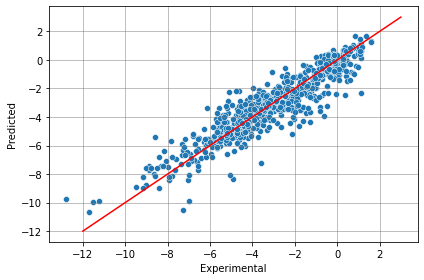

In [120]:
x=np.linspace(-12,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytrn,ypred.reshape(720))
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('mlpcvpred.jpg', format='jpeg', dpi=400)
plt.show()

## VAL

In [121]:
mlp_reg.fit(xtrn, ytrn.values)

ypred_tst = mlp_reg.predict(xtst)

scores = get_scores(ytst, ypred_tst, test=True)

scores = pd.DataFrame(scores, index=['MLP'])

val_perf = val_perf.append([scores])
val_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
MLR,1.276849,0.717738,47.777778,62.222222
RR,1.276514,0.717964,47.777778,62.222222
Lasso,1.276503,0.718441,47.777778,62.222222
SVR,1.286681,0.713185,50.555556,62.222222
kSVR,1.103858,0.793697,56.666667,70.000000
RF,1.069252,0.807511,58.333333,71.111111
ET,1.003911,0.832813,58.333333,72.777778
PCR,1.296344,0.708884,46.666667,63.333333
PLS,1.280032,0.716295,48.333333,62.222222
GP,1.090043,0.799711,55.000000,70.000000


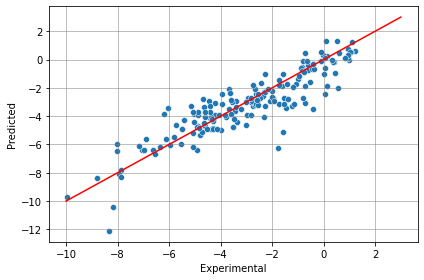

In [122]:
x=np.linspace(-10,3,100)
sns.lineplot(x,y=x,color='red')
sns.scatterplot(ytst,ypred_tst.reshape(180))
plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.grid(linestyle='-', linewidth='0.5', color='gray')
plt.tight_layout()
plt.savefig('mlptstpred.jpg', format='jpeg', dpi=400)
plt.show()

# Understanding Results

In [125]:
metrics_df=val_perf.loc[['MLR','RR','Lasso','SVR','PCR','PLS','RF','ET','Bag','ADAB','GRADB','kSVR','MLP']]
metrics_df['Pearson-rsquared']=metrics_df['Pearson-rsquare']
metrics_df.drop(['Pearson-rsquare'],axis=1,inplace=True)

metrics_df

,RMSE,%P±0.7,%P±1.0,Pearson-rsquared
MLR,1.276849,47.777778,62.222222,0.717738
RR,1.276514,47.777778,62.222222,0.717964
Lasso,1.276503,47.777778,62.222222,0.718441
SVR,1.286681,50.555556,62.222222,0.713185
PCR,1.296344,46.666667,63.333333,0.708884
PLS,1.280032,48.333333,62.222222,0.716295
RF,1.069252,58.333333,71.111111,0.807511
ET,1.003911,58.333333,72.777778,0.832813
Bag,1.082679,57.222222,70.000000,0.802184
ADAB,1.092430,48.888889,65.555556,0.804262


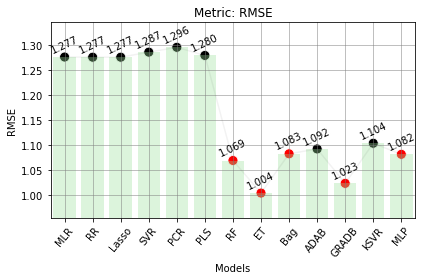

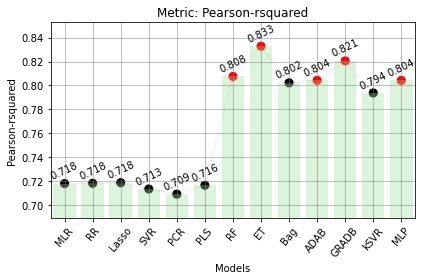

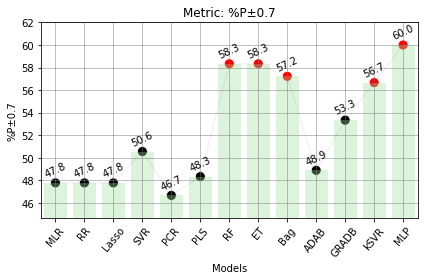

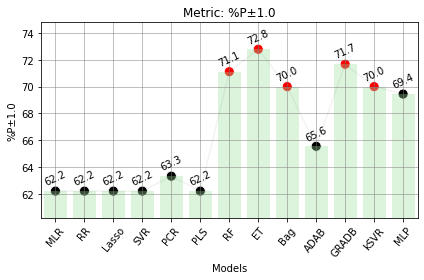

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt


metrics=['RMSE','Pearson-rsquared','%P±0.7','%P±1.0']
deltas = [0.05, 0.02, 2,2]

for i in range(4):
    delta=deltas[i]
    f, ax = plt.subplots()
    metric=metrics[i]
#     sns.set_style("whitegrid")
#     sns.set_style("ticks",{'axes.grid' : True})
    x=metrics_df.index
    y=metrics_df[metric]
    # metrics_df.reset_index(inplace=True)
    sns.lineplot(x,y,ax=ax, alpha=0.05, color='black')

    # For Non-RMSE
    ymax=sorted(y,reverse=True)[:5]
    ymax=min(ymax)
    mask = np.array(y) >= ymax
    color = np.where(mask, 'red', 'black')

    if metric=='RMSE':
        # # For RMSE
        ymax=sorted(y,reverse=False)[:5]
        ymax=max(ymax)
        mask = np.array(y) <= ymax
        color = np.where(mask, 'red', 'black')


    sns.scatterplot(x,y,c=color,s=100,ax=ax)
    sns.barplot(x,y,color='lightgreen',alpha=0.35,ax=ax)
    
    xmax = x[np.argmax(y)]
    ymax = y.max()
    
    for p in ax.patches:
        if metric not in ['%P±0.7','%P±1.0']:
            ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', rotation=25, xytext=(0, 13), textcoords='offset points')  #vertical bars
        else:
            ax.annotate("%.1f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', rotation=25, xytext=(0, 13), textcoords='offset points')  #vertical bars

    ax.set_ylim([min(y)-delta, max(y)+delta])
    ax.grid(linestyle='-', linewidth='0.5', color='gray')
    ax.set_title(f'Metric: {metric}')
    
    plt.xticks(rotation=50)
    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.tight_layout()
#     plt.savefig(f'{metric}0.jpg', format='jpeg', dpi=1200)
    plt.show()

# Consensus prediction

## CV

In [127]:
cv = KFold(10)
ksvm_preds = cross_val_predict(ksvm_reg, xtrn, ytrn, cv=cv)
et_preds = cross_val_predict(et_reg, xtrn, ytrn, cv=cv)
forest_preds = cross_val_predict(forest_reg, xtrn, ytrn, cv=cv)
# gradb_preds = cross_val_predict(gradb_reg, xtrn, ytrn, cv=cv)
mlp_preds = cross_val_predict(mlp_reg, xtrn, ytrn, cv=cv)
bag_preds = cross_val_predict(mlp_reg, xtrn, ytrn, cv=cv)

In [128]:
ksvm_reg.fit(xtrn, ytrn.values)
ksvm_preds_v = ksvm_reg.predict(xtst)

et_reg.fit(xtrn, ytrn.values)
et_preds_v = et_reg.predict(xtst)

# gradb_reg.fit(xtrn, ytrn.values)
# gradb_preds_v = gradb_reg.predict(xtst)

forest_reg.fit(xtrn, ytrn.values)
forest_preds_v = forest_reg.predict(xtst)

bag_reg.fit(xtrn, ytrn.values)
bag_preds_v = bag_reg.predict(xtst)

mlp_reg.fit(xtrn, ytrn.values)
mlp_preds_v = mlp_reg.predict(xtst)

In [129]:
### Consensus predictions

print("GETTING CONSENSUS")
# CV
consensus_preds=[]
for i in range(len(ksvm_preds)):
  consensus = [ksvm_preds[i],et_preds[i],forest_preds[i],mlp_preds[i],bag_preds[i]]
  consensus_preds.append(np.mean(consensus))
consensus_preds=np.array(consensus_preds)

trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]
ypred_f = [consensus_preds[j] for i, j in cv.split(xtrn,ytrn)]
scores = get_scores(trgt_f, ypred_f)
cncv_perf = pd.DataFrame(scores, index=['Consensus_CV_Mean'])

consensus_preds=[]
for i in range(len(ksvm_preds)):
  consensus = [ksvm_preds[i],et_preds[i],forest_preds[i],mlp_preds[i],bag_preds[i]]
  consensus_preds.append(np.median(consensus))
consensus_preds=np.array(consensus_preds)

trgt_f = [ytrn[j] for i, j in cv.split(xtrn,ytrn)]
ypred_f = [consensus_preds[j] for i, j in cv.split(xtrn,ytrn)]
scores = get_scores(trgt_f, ypred_f)
scores = pd.DataFrame(scores, index=['Consensus_CV_Median'])
cncv_perf = cncv_perf.append([scores])


# VAL
consensus_preds=[]
for i in range(len(ksvm_preds_v)):
  consensus = [ksvm_preds_v[i],et_preds_v[i],forest_preds_v[i],mlp_preds_v[i],bag_preds_v[i]]
  consensus_preds.append(np.mean(consensus))
consensus_preds=np.array(consensus_preds)

scores = get_scores(ytst,consensus_preds, test=True)
cnval_perf = pd.DataFrame(scores, index=['Consensus_VAL_Mean'])


consensus_preds=[]
for i in range(len(ksvm_preds_v)):
  consensus = [ksvm_preds_v[i],et_preds_v[i],forest_preds_v[i],mlp_preds_v[i],bag_preds_v[i]]
  consensus_preds.append(np.median(consensus))
consensus_preds=np.array(consensus_preds)

scores = get_scores(ytst,consensus_preds, test=True)
scores = pd.DataFrame(scores, index=['Consensus_VAL_Median'])
cnval_perf = cnval_perf.append([scores])

print("SAVING CSVs")
# cncv_perf.to_csv(f'CNCV_G_sol.csv')
# cnval_perf.to_csv(f'CNVAL_G_sol.csv')

print("## ## DONE ## ##")

GETTING CONSENSUS
SAVING CSVs
## ## DONE ## ##


In [130]:
# With mlp_reg and NO bag_reg
cnval_perf

,RMSE,Pearson-rsquare,%P±0.7,%P±1.0
Consensus_VAL_Mean,1.008554,0.829684,60.555556,75.000000
Consensus_VAL_Median,1.018026,0.827338,60.555556,73.888889
